In [1]:
from vpython import (
    canvas, triangle, vector, vertex, color, quad, distant_light, local_light, points
)
import numpy as np
from scipy.interpolate import Rbf, RBFInterpolator
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay

<IPython.core.display.Javascript object>

In [2]:
#NEXT: multimilion extra mega obs point to be seed to interpolator

# le drillhole points x, y, z, d
# TARGET: isosurface 8 ?
x = [0, 4, -1, 5]
y = [1, 2, 3, -5]

obs = [
    [0, -1, 0, 1],
    [0, -1, -1, 2],
    [0, -1, -2, 3],
    [0, -1, -3, 4],
    [0, -1, -4, 5],
    [0, -1, -5, 6],
    [0, -1, -6, 5],
    [0, -1, -7, 4],
    [0, -1, -8, 3],
    [0, -1, -9, 2],
    ######
    [4, 2, 0, 1],
    [4, 2, -1, 2],
    [4, 2, -2, 3],
    [4, 2, -3, 4],
    [4, 2, -4, 5],
    [4, 2, -5, 6],
    [4, 2, -6, 7],
    [4, 2, -7, 8],
    [4, 2, -8, 9],
    [4, 2, -9, 8],
    ######
    [-1, 3, 0, 1],
    [-1, 3, -1, 2],
    [-1, 3, -2, 3],
    [-1, 3, -3, 4],
    [-1, 3, -4, 5],
    [-1, 3, -5, 6],
    [-1, 3, -6, 7],
    [-1, 3, -7, 8],
    [-1, 3, -8, 9],
    [-1, 3, -9, 8],
    ######
    [5, -5, 0, 1],
    [5, -5, -1, 2],
    [5, -5, -2, 3],
    [5, -5, -3, 4],
    [5, -5, -4, 5],
    [5, -5, -5, 6],
    [5, -5, -6, 5],
    [5, -5, -7, 4],
    [5, -5, -8, 3],
    [5, -5, -9, 2],
    ######
]

In [3]:
x = [item[0] for item in obs]
y = [item[1] for item in obs]
z = [item[2] for item in obs]
d = [item[3] for item in obs]

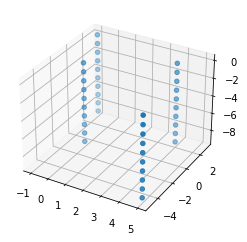

In [4]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(x, y, z)

plt.show()

In [5]:
# create 10x10X10 surface (?)

dim = 40

X = np.linspace(
    start=min(x),
    stop=max(x),
    num=dim
)

Y = np.linspace(
    start=min(y),
    stop=max(y),
    num=dim
)

Z = np.linspace(
    start=min(z),
    stop=max(z),
    num=dim
)

XD, YD, ZD = np.meshgrid(X, Y, Z)

In [6]:
%%time
# using interpolate.Rbf

rbfi = Rbf(x, y, z, d)
DD = rbfi(XD, YD, ZD)
print(DD.shape)

(40, 40, 40)
CPU times: user 164 ms, sys: 471 ms, total: 635 ms
Wall time: 59.2 ms


In [7]:
%%time
# using RBFInterpolator

# 3d mesh cannot use 'thin_plate_spline', qubic, quintic why?

xyz = [[item, y[i], z[i]] for i, item in enumerate(x)]
rbfi = RBFInterpolator(
    xyz,
    d,
    neighbors=dim,
    kernel='gaussian',
    epsilon=1
)

XYZ = []
for x_ in X:
    for y_ in Y:
        for z_ in Z:
            XYZ.append([x_, y_, z_])
DD = rbfi(XYZ)
print(DD.shape)

CPU times: user 205 ms, sys: 693 ms, total: 898 ms
Wall time: 83.3 ms


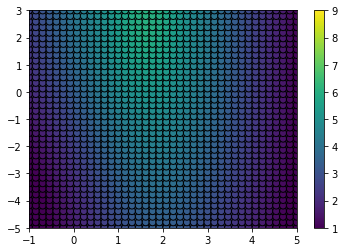

In [8]:
# slice
iplot = 6

xplot, yplot = np.meshgrid(X, Y)
vplot = DD[iplot]

fig, ax = plt.subplots()
ax.pcolormesh(xplot, yplot, vplot, shading='gouraud', vmin=min(d), vmax=max(d))
p = ax.scatter(xplot, yplot, c=vplot, s=50, ec='k', vmin=min(d), vmax=max(d))
fig.colorbar(p)
plt.show()

/tmp/ipykernel_52926/614736476.py:5: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  fig.colorbar(p)


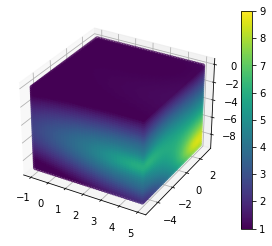

In [9]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(XD.reshape(-1), YD.reshape(-1), ZD.reshape(-1), c=DD.reshape(-1), vmin=min(d), vmax=max(d))
# ax.pcolormesh(xplot, yplot, vplot, shading='gouraud', vmin=min(d), vmax=max(d))
fig.colorbar(p)
plt.show()

In [10]:
target_val = 7
delta = 0.75

# QUAD TO TRONG
trimesh.geometry.triangulate_quads  
https://trimsh.org/trimesh.geometry.html  

In [12]:
# get xyz of d=?

# attempt #1: grid.filter(d > target) -> triangulation

DD_rsh = DD.reshape(dim, dim, -1)
DD_rsh.shape

ni, nj, nk = DD_rsh.shape

points = []
vale = []

for i in range(ni):
    for j in range(nj):
        for k in range(nk):
            if DD_rsh[i][j][k] >= (target_val - delta) and DD_rsh[i][j][k] <= (target_val + delta):
                points.append([
                    XD[i][j][k],
                    YD[i][j][k],
                    ZD[i][j][k],
                    DD_rsh[i][j][k],
                ])

# points.sort()
# points

tri = Delaunay([item[:3] for item in points], incremental=True)

triangles = tri.points
vertices = tri.vertices

In [13]:
def le_color(val, maxval=1, minval=0):
    vale = val / (maxval - minval)
    return vector(vale, 1-vale, 0)


scene = canvas()

# https://www.glowscript.org/docs/VPythonDocs/color.html

mind = min(d)
maxd = max(d)

quads = None
for vert in vertices:
#     print(vert)
    quads = [
        [*triangles[trong_id],]
        for trong_id in vert
    ]
    verts = [
        vertex(
            pos=vector(*item),
            color=le_color(points[i][3], maxd, mind),
        ) for i, item in enumerate(quads)
    ]
    quad(vs=verts)

# scene.camera.follow(scene.objects[0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
# attempt #2: triangluation -> filter(rbfi(points) >= 5)
# BROKEN at dim > 10
# get all verts where each point <= 4.9 and >= 5.1
# get all verts where 3/4 point <= 4.9 and >= 5.1
# get all verts where 2/4 point <=4.9 and >= 5.1
# get all verts where 1/4 point <=4.9 and >= 5.1

tri = Delaunay(XYZ)

vale = rbfi(tri.points)

le_vert = []

print(tri.vertices.shape)
print(tri.points.shape)

for i, vert in enumerate(tri.vertices):
    vale_ = []
    point_ = []
    for trong_id in vert:
        if vale[trong_id] >= (target_val - delta) and vale[trong_id] <= (target_val + delta):
            vale_.append(vale[trong_id])
    if len(vale_) > 2:
#         print(i, vale_)
        le_vert.append(vert)
np.shape(le_vert)

triangles = tri.points
vertices = le_vert

(427645, 4)
(64000, 3)


In [15]:
print(tri.simplices[0], tri.vertices[0])

[24083 25724 25683 25723] [24083 25724 25683 25723]


In [16]:
def le_color(val, maxval=1, minval=0):
    vale = val / (maxval - minval)
    return vector(vale, 1-vale, 0)


scene = canvas()

# https://www.glowscript.org/docs/VPythonDocs/color.html

mind = min(d)
maxd = max(d)

quads = None
for vert in vertices:
#     print(vert)
    quads = [
        [*triangles[trong_id],]
        for trong_id in vert
    ]
    verts = [
        vertex(
            pos=vector(*item),
            color=le_color(points[i][3], maxd, mind),
        ) for i, item in enumerate(quads)
    ]
    if len(verts) == 3:
        triangle(vs=verts)
    elif len(verts) == 4:
        quad(vs=verts)

scene.lights = []
lamp = local_light(
    pos=vector(0,0,20),
    color=color.yellow
)
scene.center = vector(0, 0, 0)

<IPython.core.display.Javascript object>